# Example: NEURON plus .swc morphology file

Example utilizing the **`LFPykit`** module for predictions of extracellular potentials using 
the line source approximation implementation `LineSourcePotential` with a passive neuron model set up in the NEURON simulation environment (https://neuron.yale.edu/neuron/, https://github.com/neuronsimulator/nrn). 

The neuron receives sinusoid synaptic current input in one arbitrary chosen segment. 
Its morphology is defined in the file `single_cell.swc`. 

The example produces comparable output as the `Example_Arbor_swc.ipynb` and `Example_LFPy_swc.ipynb` notebooks. 
For this a couple of modified `CellGeometry` and `LineSourcePotential` classes have been defined below, similar to `Example_LFPy_pt3d.ipynb` and `Example_LFPy_swc.ipynb`

In [18]:
%matplotlib inline

In [19]:
## NEURON may be installed using pip:
#!pip install neuron==8.2.1

In [20]:
## if running on mybinder or similar, uncomment and run the following to install LFPykit. 
## Then restart the kernel.
#!pip install ..

In [21]:
## compile sinsyn.mod NMODL file
#!nrnivmodl

In [22]:
# import modules
import numpy as np
import neuron
import lfpykit
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

In [23]:
# load some hoc routines for reading morphology files:
neuron.h.load_file("stdlib.hoc")
neuron.h.load_file("import3d.hoc")
neuron.h.load_file("stdrun.hoc")

1.0

In [24]:
class CellSimulation(object):
    '''Passive cell set up in NEURON from .swc file format + simulation control'''
    def __init__(self):
        self.load_morphology()
        self.set_biophys()
        self.stimlist = []
        self.set_stim()
        
    def load_morphology(self):
        cell = neuron.h.Import3d_SWC_read()
        cell.input("single_cell.swc")  # morphology file
        i3d = neuron.h.Import3d_GUI(cell, False)
        i3d.instantiate(self)
    
    def set_biophys(self):
        for sec in self.all:
            sec.cm = 1.  # membrane capacitance (uF/cm2)
            sec.Ra = 10000.  # cytoplasmic resistivity (ohm cm)
            sec.insert('pas')
            sec.g_pas = 0.0001  # leak conductivity (S/cm2)
            sec.e_pas = -65.  # leak reversal potential
            if 'soma' not in sec.name():
                sec.nseg = 3  # numbers of segments (compartments) per section
    
    def set_stim(self):
        '''create sinusoid "synapse" current'''
        s = neuron.h.SinSyn(1/6, sec=self.apic[1])
        s.delay = 0  # ms
        s.freq = 100.  # Hz
        s.phase = np.pi  # rad
        s.dur = 1E8  # ms
        self.stimlist.append(s)

    def create_recorders(self):
        self.create_time_recorder()
        self.create_voltage_recorders()
        self.create_current_recorders()

    def create_time_recorder(self):
        self.time = neuron.h.Vector()
        self.time.record(neuron.h._ref_t)

    def create_voltage_recorders(self):
        self.V_m = []
        for sec in self.all:
            for seg in sec:
                self.V_m.append(neuron.h.Vector())
                self.V_m[-1].record(seg._ref_v)

    def create_current_recorders(self):
        self.I_m = []
        for sec in self.all:
            for seg in sec:
                self.I_m.append(neuron.h.Vector())
                self.I_m[-1].record(seg._ref_i_membrane_)

    def _initialize(self, v_init, dt):
        cvode = neuron.h.CVode()
        cvode.use_fast_imem(1)
        cvode.active(0)
        neuron.h.dt = dt
        
        self.create_recorders()

        neuron.h.finitialize(v_init)
        if cvode.active():
            cvode.re_init()
        else:
            neuron.h.fcurrent()
        neuron.h.frecord_init()

    def _integrate(self, tstop):
        neuron.h.continuerun(tstop)

    def _finalize(self):
        self.time = np.array(self.time)
        self.I_m = np.array(self.I_m)
        self.V_m = np.array(self.V_m)
    
    def simulate(self, v_init=-65, tstop=500, dt=0.1):
        '''
        Parameters
        ----------
        v_init: float
            initial voltage (mV)
        tstop: float
            simulation duration (ms)
        dt: float
            temporal step size (ms)
        '''
        self._initialize(v_init, dt)
        self._integrate(tstop)
        self._finalize()
        

In [25]:
class Pt3dCellGeometry(lfpykit.CellGeometry):
    '''
    Class inherited from  ``lfpykit.CellGeometry`` for easier forward-model
    predictions from NEURON that keeps track of pt3d information
    for each compartment.

    Parameters
    ----------
    cell: ``Cell`` object

    See also
    --------
    lfpykit.CellGeometry
    '''
    def __init__(self, cell):
        self.x3d, self.y3d, self.z3d, self.diam3d, self.arc3d = \
                self._collect_pt3d(cell)

        x, y, z, d = [np.array([], dtype=float).reshape((0, 2))] * 4
        c_ind = np.array([], dtype=int)  # tracks which compartment owns segment
        idx = 0
        for i, sec in enumerate(cell.all):
            xp = (self.arc3d[i] / self.arc3d[i][-1])
            seg_l = 1 / sec.nseg / 2 
            for seg in sec:
                seg_x = np.array([seg.x - seg_l, seg.x + seg_l])
                ind = (xp > seg_x.min()) & (xp < seg_x.max())
                seg_x = np.sort(np.r_[seg_x, xp[ind]])
                
                # interpolate to get values for start-, pt3d-, and end-point for search segment:
                x_tmp = np.interp(seg_x, xp, self.x3d[i])
                y_tmp = np.interp(seg_x, xp, self.y3d[i])
                z_tmp = np.interp(seg_x, xp, self.z3d[i])
                d_tmp = np.interp(seg_x, xp, self.diam3d[i])
                
                # store
                x = np.row_stack([x, np.c_[x_tmp[:-1], x_tmp[1:]]])
                y = np.row_stack([y, np.c_[y_tmp[:-1], y_tmp[1:]]])
                z = np.row_stack([z, np.c_[z_tmp[:-1], z_tmp[1:]]])
                d = np.row_stack([d, np.c_[d_tmp[:-1], d_tmp[1:]]])
                
                c_ind = np.r_[c_ind, np.ones(seg_x.size - 1) * idx]
                idx += 1              
                
        super().__init__(x=x, y=y, z=z, d=d)
        self._c_ind = c_ind

    def _collect_pt3d(self, cell):
        """collect the pt3d info, for each section

        Returns
        -------
        x3d: list of ndarray
            x-coordinates from h.x3d()
        y3d: list of ndarray
            y-coordinates from h.y3d()
        z3d: list of ndarray
            z-coordinates from h.z3d()
        diam3d: list of ndarray
            diameter from h.diam3d()
        arc3d: list of ndarray
            arclength from h.arc3d()
        """
        x3d, y3d, z3d, diam3d, arc3d = [], [], [], [], []

        for sec in cell.all:
            n3d = int(neuron.h.n3d(sec=sec))
            x3d_i, y3d_i, z3d_i, diam3d_i, arc3d_i = np.zeros((5, n3d))
            for i in range(n3d):
                x3d_i[i] = neuron.h.x3d(i, sec=sec)
                y3d_i[i] = neuron.h.y3d(i, sec=sec)
                z3d_i[i] = neuron.h.z3d(i, sec=sec)
                diam3d_i[i] = neuron.h.diam3d(i, sec=sec)
                arc3d_i[i] = neuron.h.arc3d(i, sec=sec)

            x3d.append(x3d_i)
            y3d.append(y3d_i)
            z3d.append(z3d_i)
            diam3d.append(diam3d_i)
            arc3d.append(arc3d_i)
        
        return x3d, y3d, z3d, diam3d, arc3d  

In [26]:
class Pt3dLineSourcePotential(lfpykit.LineSourcePotential):
    '''subclass of ``lfpykit.LineSourcePotential`` modified for
    instances of ``Pt3dCellGeometry``.
    Each compartment may consist of several segments, and this implementation
    accounts for their contributions normalized by surface area, that is,
    we assume constant transmembrane current density per area across each compartment
    and constant current source density per unit length per segment
    (inherent in the line-source approximation).

    Parameters
    ----------
    cell: object
        ``Pt3dCellGeometry`` instance or similar.
    x: ndarray of floats
        x-position of measurement sites (µm)
    y: ndarray of floats
        y-position of measurement sites (µm)
    z: ndarray of floats
        z-position of measurement sites (µm)
    sigma: float > 0
        scalar extracellular conductivity (S/m)

    See also
    --------
    lfpykit.LineSourcePotential
    '''

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._get_transformation_matrix = super().get_transformation_matrix

    def get_transformation_matrix(self):
        '''Get linear response matrix

        Returns
        -------
        response_matrix: ndarray
            shape (n_coords, n_CVs) ndarray
        '''
        M_tmp = self._get_transformation_matrix()
        n_comps = np.unique(self.cell._c_ind).size
        M = np.zeros((self.x.size, n_comps))
        for i in range(n_comps):
            inds = self.cell._c_ind == i
            M[:, i] = M_tmp[:, inds] @ (self.cell.area[inds] /
                                        self.cell.area[inds].sum())

        return M

In [27]:
# instantiate cell and run simulation
cell = CellSimulation()
cell.simulate()

In [28]:
###############################################################################
# compute extracellular potential using pt3d information
###############################################################################

# create ``Pt3dCellGeometry`` instance
cell_geometry = Pt3dCellGeometry(cell)

# locations where extracellular potential is predicted 
dx = 1
dz = 1
axis = np.round([cell_geometry.x.min()-10, cell_geometry.x.max()+10, cell_geometry.y.min()-10, cell_geometry.y.max()+10])
# axis = np.round(axis)
X, Y = np.meshgrid(np.linspace(axis[0], axis[1], int(np.diff(axis[:2]) // dx) + 1), 
                   np.linspace(axis[2], axis[3], int(np.diff(axis[2:]) // dz) + 1))
Z = np.zeros_like(X)


# LineSourcePotential object, get mapping
lsp_pt3d = Pt3dLineSourcePotential(cell=cell_geometry,                                   
                                   x=X.flatten(), 
                                   y=Y.flatten(), 
                                   z=Z.flatten())
M = lsp_pt3d.get_transformation_matrix()

# Extracellular potential in x,z-plane coordinates   
V_e = M @ cell.I_m

## Plotting
Plot the morphology and extracellular potential prediction

In [29]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw matplotlib colorbar without resizing the axes object
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cax.grid(False)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

In [30]:
def get_polycollection(cell_geometry, V_m, vlims=[-66, -64], cmap='viridis'):
    '''
    Parameters
    ----------
    cell_geometry: ``Pt3dCellGeometry`` like object
    V_m: ndarray
        membrane voltages at some time point
    vlims: list
        color limits
    cmap: str
        matplotlib colormap name

    Returns
    -------
    PolyCollection
    '''
    norm = plt.Normalize(vmin=vlims[0], vmax=vlims[1], clip=True)
    colors = [plt.get_cmap(cmap)(norm(v)) for v in V_m]
    zips = []
    for i in range(V_m.size):
        inds = cell_geometry._c_ind == i
        zips.append(create_polygon(cell_geometry.x[inds, ].flatten(),
                                   cell_geometry.y[inds, ].flatten(),
                                   cell_geometry.d[inds, ].flatten()))
    polycol = PolyCollection(zips,
                             edgecolors=colors,
                             facecolors=colors,
                             linewidths=0.)
    return polycol

In [31]:
def get_segment_outlines(cell_geometry):
    '''
    Parameters
    ----------
    cell_geometry: ``Pt3dCellGeometry`` object
    cmap: str
        matplotlib colormap name

    Returns
    -------
    PolyCollection
    '''
    zips = []
    for x_, y_, d_ in zip(cell_geometry.x, cell_geometry.y, cell_geometry.d):
        zips.append(create_polygon(x_, y_, d_))
    polycol = PolyCollection(zips,
                             edgecolors='k',
                             facecolors='none',
                             linewidths=0.5)
    return polycol

In [32]:
def create_polygon(x, y, d):
    """create an outline for each segment defined by 1D arrays `x`, `y`, `d`
    in x,y-plane which can be drawn using `plt.Polygon`
    
    Parameters
    ----------
    x: ndarray
    y: ndarray
    d: ndarray
    
    Returns
    -------
    x, y: nested list
    """
    x_grad = np.gradient(x)
    y_grad = np.gradient(y)
    theta = np.arctan2(y_grad, x_grad)

    xp = np.r_[(x + 0.5 * d * np.sin(theta)).ravel(), 
               (x - 0.5 * d * np.sin(theta)).ravel()[::-1]]
    yp = np.r_[(y - 0.5 * d * np.cos(theta)).ravel(), 
               (y + 0.5 * d * np.cos(theta)).ravel()[::-1]]
    
    return list(zip(xp, yp))

In [33]:
def get_segment_outlines(cell_geometry):
    '''
    Parameters
    ----------
    cell_geometry: ``ArborCellGeometry`` object
    cmap: str
        matplotlib colormap name

    Returns
    -------
    PolyCollection
    '''
    zips = []
    for x_, y_, d_ in zip(cell_geometry.x, cell_geometry.y, cell_geometry.d):
        zips.append(create_polygon(x_, y_, d_))
    polycol = PolyCollection(zips,
                             edgecolors='k',
                             facecolors='none',
                             linewidths=0.5)
    return polycol

Text(0, 0.5, '$y$ ($\\mu$m)')

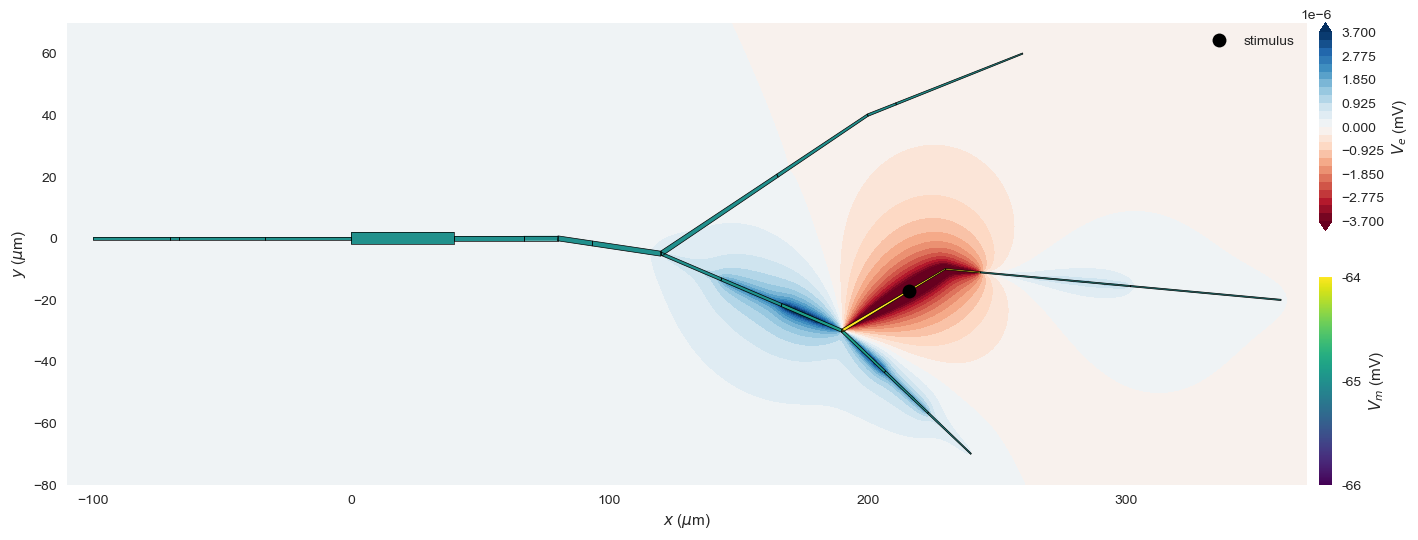

In [34]:
# show predictions at the last time point of simulation
time_index = -1

# colormap
plt.rcParams['image.cmap'] = 'viridis'

# create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=100)

# plot contours of V_e
lim = float(f'{abs(V_e).max() / 3:.1e}')
levels = np.linspace(-lim, lim, 25)
im_V_e = ax.contourf(X, Y, V_e[:, time_index].reshape(X.shape),
                     cmap='RdBu',
                     levels=levels,
                     extend='both')

# V_e colorbar:
cb = colorbar(fig, ax, im_V_e, height=0.45, voffset=0.55)
cb.set_label('$V_e$ (mV)')

# add outline of each CV
vlims = [-66., -64.]
polycol = get_polycollection(cell_geometry, cell.V_m[:, time_index], vlims=vlims)
im_V_m = ax.add_collection(polycol)

cb2 = colorbar(fig, ax, im_V_m, height=0.45)
cb2.set_ticks([0, 0.5, 1])
cb2.set_ticklabels([-66, -65, -64])
cb2.set_label(r'$V_m$ (mV)')


# draw segment outlines
ax.add_collection(get_segment_outlines(cell_geometry))

# synapse location
s = cell.stimlist[0]
sec = s.get_segment().sec
xp = [neuron.h.arc3d(i, sec=sec) / neuron.h.arc3d(sec.n3d()-1, sec=sec) for i in range(sec.n3d())]
s_x = np.interp(s.get_loc(), xp, [neuron.h.x3d(i, sec=sec) for i in range(sec.n3d())])
s_y = np.interp(s.get_loc(), xp, [neuron.h.y3d(i, sec=sec) for i in range(sec.n3d())])
ax.plot(s_x, s_y, 'ko', ms=10, label='stimulus')

ax.legend()

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_xlabel(r'$x$ ($\mu$m)')
ax.set_ylabel(r'$y$ ($\mu$m)')

## Notes on output:
The spatial discretization is here deliberately coarse with only `nseg=3` per section.
The soma consist of one section.
Hence the dendritic section receiving input about 1/6 of the way from its root 
is treated as 3 separate line sources with homogeneous current density per length unit each, even if 
the diameter and direction varies with position due to the fact 
that each compartment may  be composed of multiple pt3d segments. 

The parameter `nseg=3` above can be changed via to affect the number of compartments per section. 